In [1]:
# !pip install opencv-python

## 1. Loading images and retrieving faces

In [2]:
import cv2
import math
import numpy as np
import os
# import npwriter
from matplotlib import pyplot as plt

In [3]:
training_data_dir = "data/training"
test_data_dir = "data/test"

In [4]:
def load_image(image_path: str):
    return cv2.imread(image_path)

def load_images(dir: str):
    return [
        load_image(os.path.join(dir, filename))
        for filename in os.listdir(dir)
    ]

def plot_images(images: list):
    fig = plt.figure(figsize=(20,20))

    N_COLS = 3
    N_ROWS = math.ceil(len(images)/N_COLS)
    
    for i, face in enumerate(images):
        plt.subplot(N_ROWS, N_COLS, i+1)
        plt.imshow(images[i])
    plt.show()

### Training images

Found 3 in training set


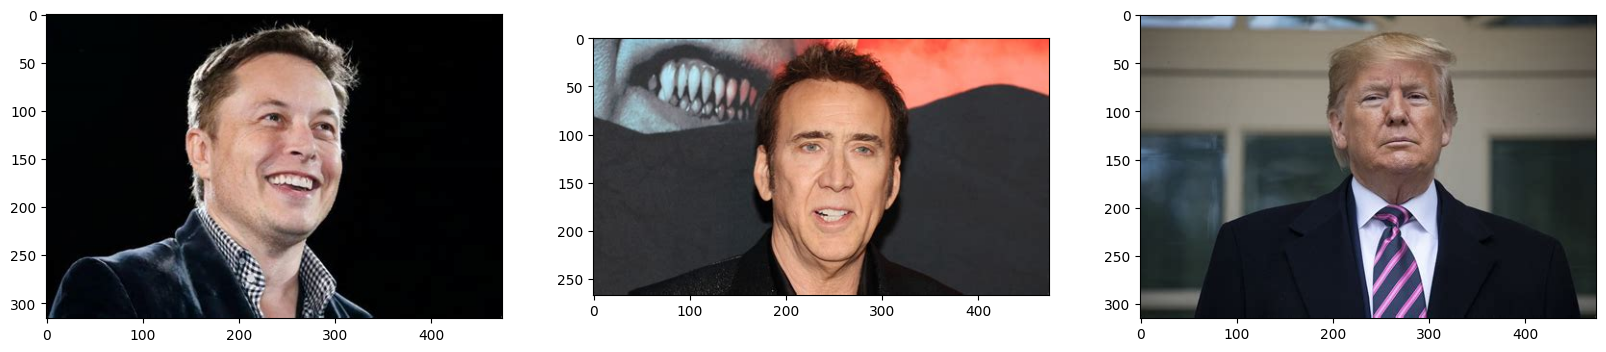

In [5]:
training_images = load_images(training_data_dir)
print(f"Found {len(training_images)} in training set")
plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in training_images])


### Test images

Found 3 images in test set


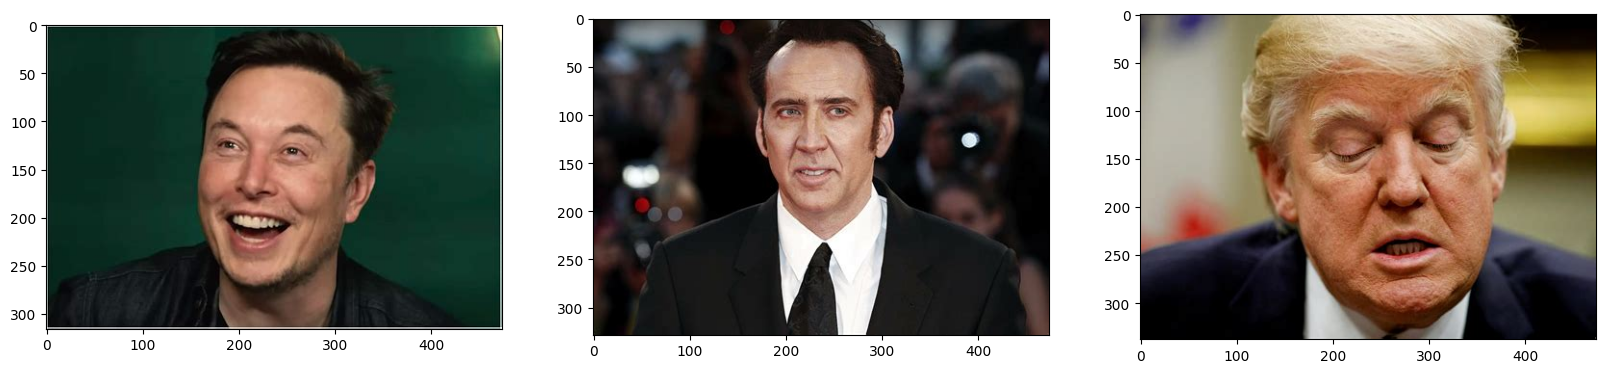

In [6]:
test_images = load_images(test_data_dir)
print(f"Found {len(test_images)} images in test set")
plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in test_images])

### Traing faces

In [7]:
face_detector_cascade_file = "haarcascade_frontalface_default.xml"
# initialise classifier and ascertain it is loaded

face_detector_classifier = cv2.CascadeClassifier(face_detector_cascade_file)
assert not face_detector_classifier.empty()

In [8]:
class FaceFinder:
    def __init__(self, face_classifier: cv2.CascadeClassifier):
        if not face_classifier.empty():
            self.face_classifier = face_classifier
        else:
            raise ValueError("Empty Classifier")

    def retrieve_rectangle_pixels(self, image: cv2.cvtColor, x: int, y: int, width: int , height: int):
        return image[y:y + height, x:x + width]
    
    # Get the first face found in image or None
    def get_face(self, image: cv2.cvtColor):
        detected_face_rectangles = self.face_classifier.detectMultiScale(image=image, scaleFactor=1.5, minNeighbors=5)

        if len(detected_face_rectangles) <= 0:
            return None
        x, y, width, height = detected_face_rectangles[0]
        return self.retrieve_rectangle_pixels(image=image, x=x, y=y, width=width, height=height)         
            

In [9]:
face_finder = FaceFinder(face_classifier=face_detector_classifier)

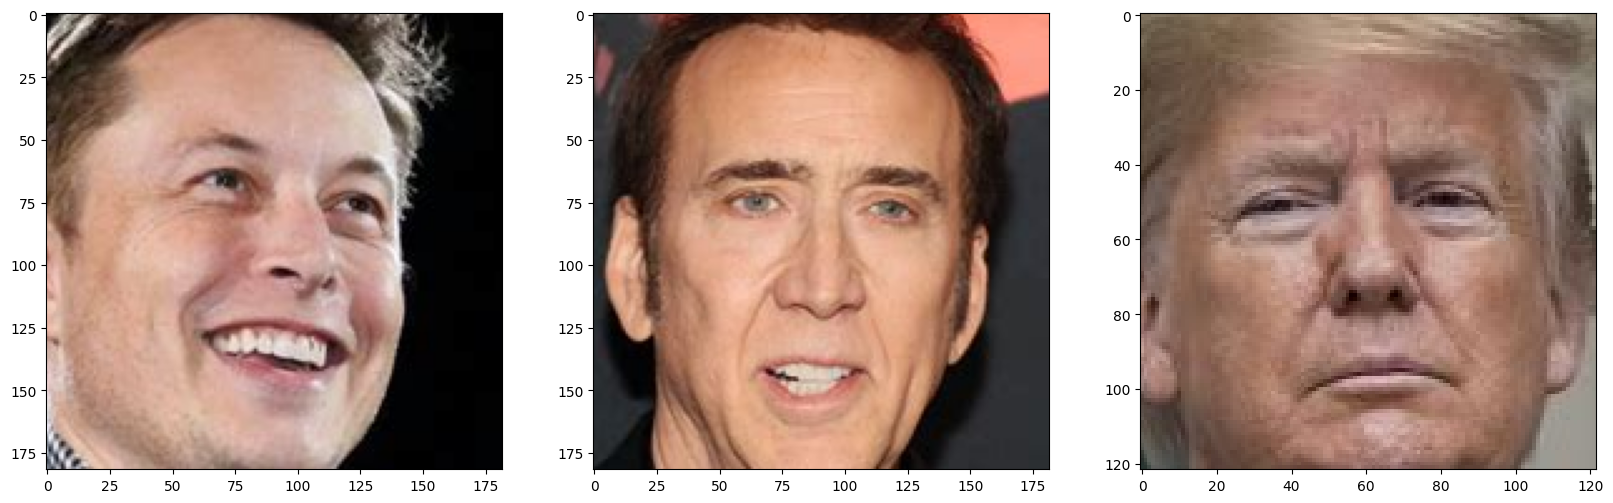

In [10]:
training_faces = [face_finder.get_face(image) for image in training_images]
plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in training_faces])

### Test faces

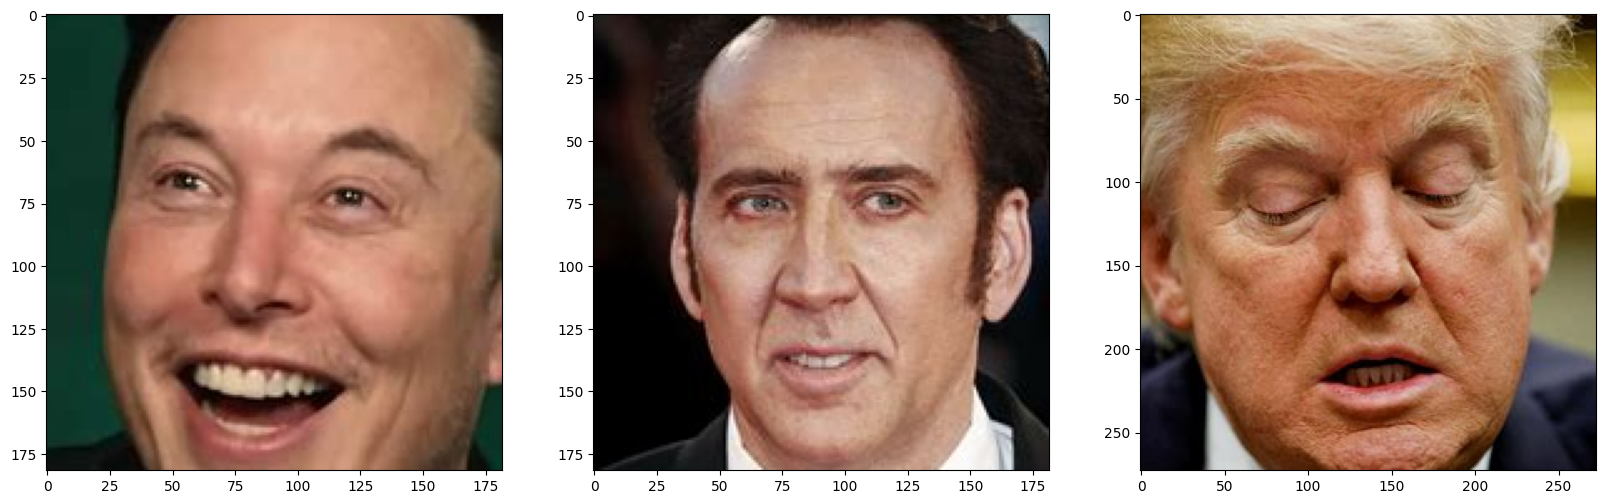

In [11]:
test_faces = [face_finder.get_face(image) for image in test_images]
plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in test_faces])

## 2. Preprocessing

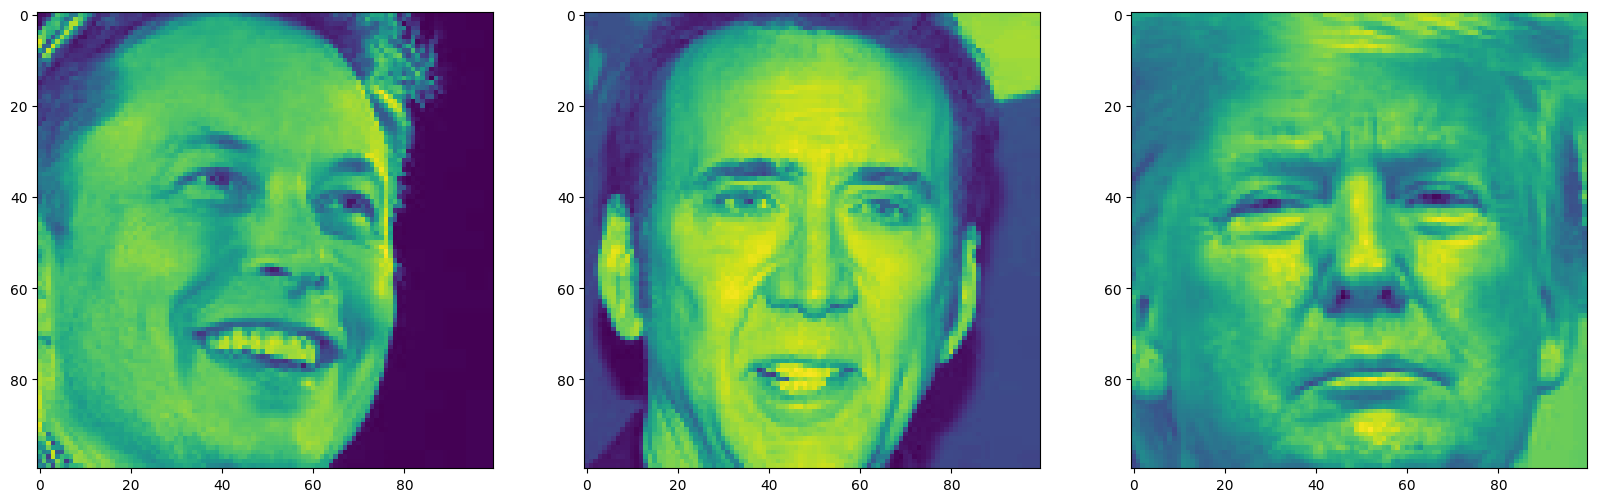

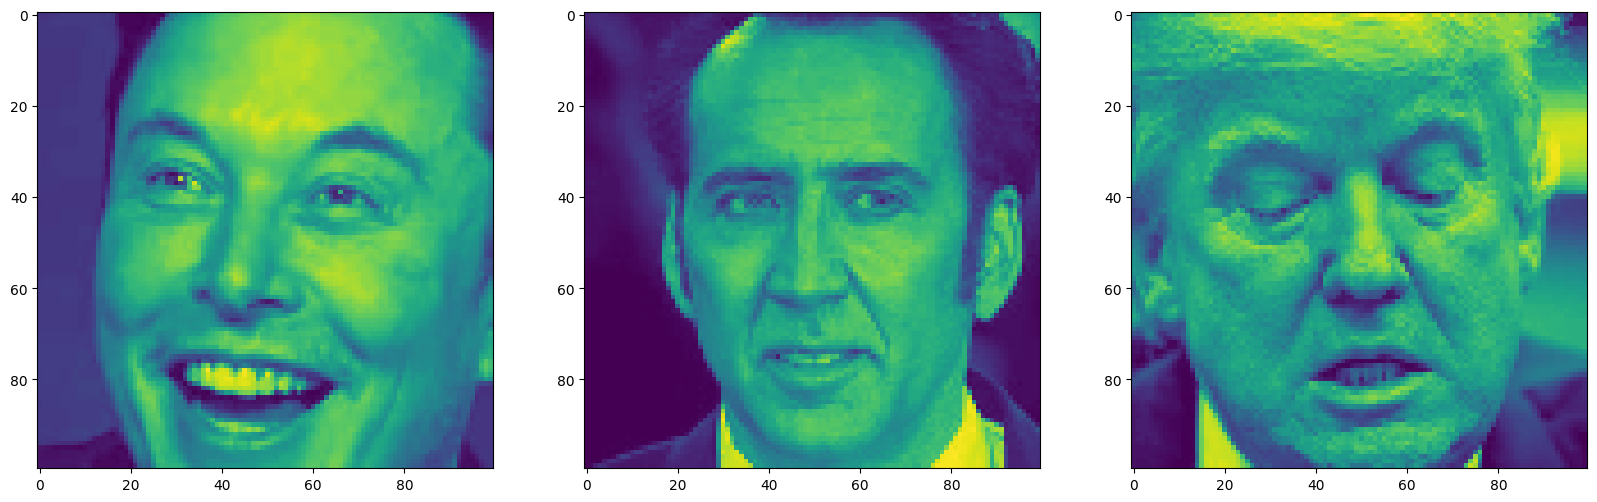

In [12]:
### Convert to Grayscale and save

STD_FACE_SIZE = (100, 100)

def resize_face(face: np.ndarray):
    return cv2.resize(face, STD_FACE_SIZE)

def convert_to_grayscale(face: np.ndarray):
    return cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

# grayscale_training_faces = [cv2.cvtColor(face, cv2.COLOR_BGR2GRAY) for face in training_faces]
grayscale_training_faces = [*map(convert_to_grayscale, training_faces)]
grayscale_test_faces = [*map(convert_to_grayscale, test_faces)]

resized_training_faces = [*map(resize_face, grayscale_training_faces)]
resized_test_faces = [*map(resize_face, grayscale_test_faces)]

plot_images(resized_training_faces)
plot_images(resized_test_faces)

## 3. Finding closest image

In [13]:
resized_training_faces[2].reshape(-1).shape

(10000,)

In [14]:
def euclidian_dist(x1, x2):        
    return np.sqrt(np.sum((x1-x2)**2))


class NearestImage:
    def __init__(self, face_finder: FaceFinder, dist_func = euclidian_dist):
        self.face_finder = face_finder
        self.dist_func = dist_func
    
    def preprocess_image(self, image: np.ndarray):
        # 1. find faces in training images
        # 2. Convert faces to grayscale
        # 3. Resive grayscale faces
        # 4. Reshape to 1d vector
        face = self.face_finder.get_face(image)
        grayscale_face = convert_to_grayscale(face)
        resized_face = resize_face(grayscale_face)
        reshaped = resized_face.reshape(-1)

        return reshaped
    
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.resized_x_train_faces = [*map(self.preprocess_image, x_train)]
        self.y_train = y_train    
   
    def find_closest_training_image(self, image):
        reshaped_vec = self.preprocess_image(image)
        dist_to_training_vectors = [
            self.dist_func(reshaped_vec, train_face_vector)
            for train_face_vector in self.resized_x_train_faces
        ]

        return np.array(dist_to_training_vectors).argmin()

    def predict(self, X_test):
        closest_training_idx = [*map(self.find_closest_training_image, X_test)]

        closest_images = [self.x_train[idx] for idx in closest_training_idx]
        predicted_labels = [self.y_train[idx] for idx in closest_training_idx]
        
        return predicted_labels, closest_images

## 4. Recognising Faces

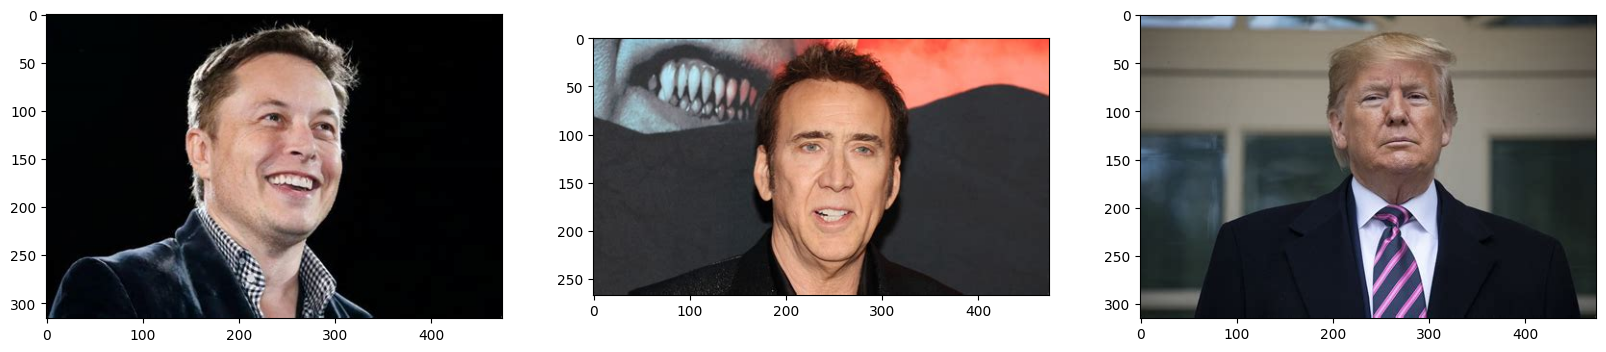

In [15]:
# 1. Load training images
training_images = load_images(training_data_dir)
plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in training_images])


In [16]:
# 2. Initialise model
model = NearestImage(face_finder=face_finder)

In [17]:
# 3. Train model
labels = ['Elon Musk', 'Nicholas Cage', 'Donald Trump']

model.fit(training_images, labels)

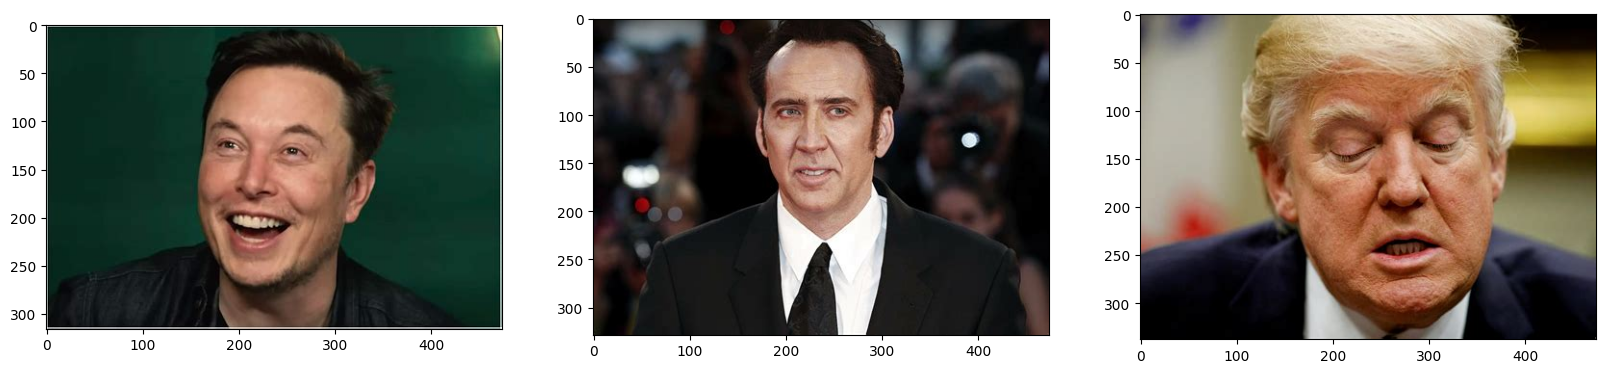

In [18]:
# 4. Load test  images
test_images = load_images(test_data_dir)
plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in test_images])

### Predicted as Elon Musk

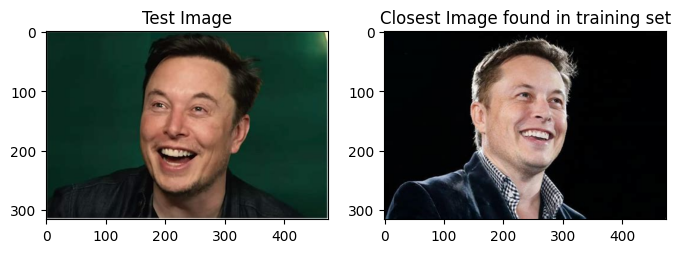

### Predicted as Nicholas Cage

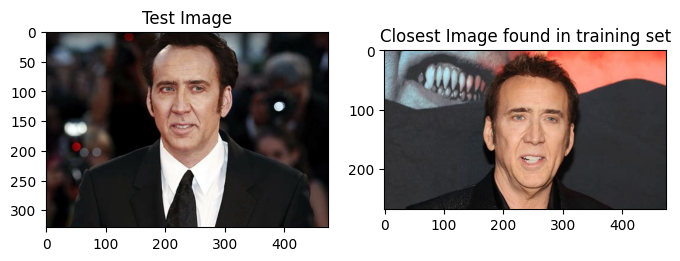

### Predicted as Donald Trump

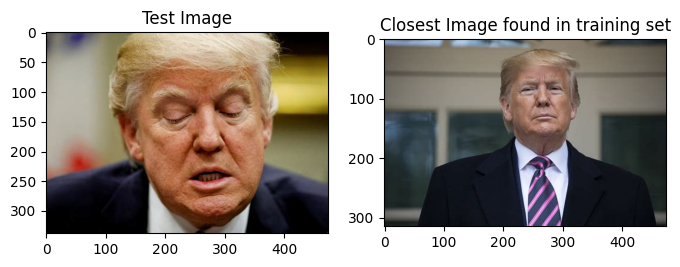

In [24]:
# 4. Prediction Time
predicted_labels, closest_images = model.predict(test_images)


from IPython.display import display, Markdown

for i, test_image in enumerate(test_images):
    display(Markdown(f"### Predicted as {predicted_labels[i]}"))
    
    fig = plt.figure(figsize=(8,8))
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Test Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(closest_images[i], cv2.COLOR_BGR2RGB))
    plt.title("Closest Image found in training set")

    plt.show()
    
    


In [20]:
[attr for attr in dir(fig) if "title" in attr]

['_suptitle', 'suptitle']